## EECS 442 PS3: Learning

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

MAITHREYAN GANESH, maithgan

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.






## Initialization

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import platform
import random
from random import randrange
from skimage.color import rgb2gray
from skimage.feature import hog
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import glob

random.seed(0)
np.random.seed(0)

# 1. Setup dataset

In this section we will download the dataset, unzip it and setup the paths to load images from.

This dataset is a very tiny subset of the popular [ImageNet](https://www.image-net.org/) dataset. This dataset is used for image classification.

This tiny dataset has **10 classes** : [ fish, English-springer, cassette-player, chain-saw, church, French-horn, garbage-truck, gas-pump, golf-ball, parachute ]  

It contains a total of **9538 training images** and **3856 test images**.

The dataset is in the format:
```
dataset
  ---train
     ---class1
     ---class2
             .
             .
  ---test
     ---class1
     ---class2
             .
             .
```
The data has been cleaned and we have provided dataloading functions below so you can directly use the dataset.


In [2]:
!wget --no-check-certificate "https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/imagenette.zip"

--2024-09-25 15:41:23--  https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/data/imagenette.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 107288983 (102M) [application/zip]
Saving to: ‘imagenette.zip’

imagenette.zip      100%[===================>] 102.32M  34.9MB/s    in 2.9s    

2024-09-25 15:41:26 (34.9 MB/s) - ‘imagenette.zip’ saved [107288983/107288983]



In [3]:
!unzip -qq "/content/imagenette.zip"

In [4]:
train_data_path = '/content/imagenette/train'
test_data_path = '/content/imagenette/test'

train_image_paths = [] #to store image paths in list
test_image_paths = []
classes = [] #to store class values

# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(sum(train_image_paths,[]))
random.shuffle(train_image_paths)

test_image_paths = list(sum(test_image_paths,[]))

# create a dictionary holding corresponding class names(text) for labels(index)
# this will help when visualizing to print class names
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [5]:
# This class derives from Dataset class in PyTorch
# Transforms are common image transformations (preprocessing steps) available in
#the torchvision.transforms module. They can be chained together using Compose.
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_shape, is_tensor = False):

        self.img_paths = img_paths
        self.img_shape = img_shape

        if is_tensor:
            self.img_transform = transforms.Compose(
                [
                    transforms.Resize((img_shape,img_shape)),
                    transforms.ToTensor()
                ]
            )
        else:
            self.img_transform = transforms.Compose(
                [
                    transforms.Resize((img_shape,img_shape))
                ]
            )

    def __getitem__(self, index):
        # this function loads a single image from its path and returns the image
        # as an array along with its label
        #The __get__item function is called internally by the DataLoader function from torchvision.transforms.

        """
        Returns an example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            img: The image at the given index
            label: The label associated with the given image
        """
        img_filepath = self.img_paths[index]
        img = Image.open(img_filepath)
        img = self.img_transform(img)
        img = np.asarray(img,dtype=np.float64)
        label = img_filepath.split('/')[-2]
        label = class_to_idx[label]
        return img, label

    def __len__(self):

        """
        Returns the size of the dataset or number of examples in the dataset
        """

        return len(self.img_paths)


## Debug Flag
Set the debug flag to true when testing.
Setting the debug flag to true will let the dataloader use only 20% of the training dataset, which makes everything run faster. This will make testing the code easier.

Once you finish the coding part please make sure to change the flag to False and rerun all the cells. This will make the colab ready for submission.

In [6]:
DEBUG = False

### OPTIONAL

You can also text all you implementations with a higher image size by setting the image size variable below.

**NOTE**: This cell needs to run once atleast

In [7]:
img_size = 32

# data_loader with load images as size 32x32
# You can try with img_size = 64 to check if it improves the accuracy

 Helper functions for gradient checking which will be used later.

In [8]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

## Load and visualize Tiny ImageNet dataset


### Visualize some examples from the dataset.

In [9]:
train_dataset = ImageDataset(train_image_paths,img_shape=150,is_tensor=False)

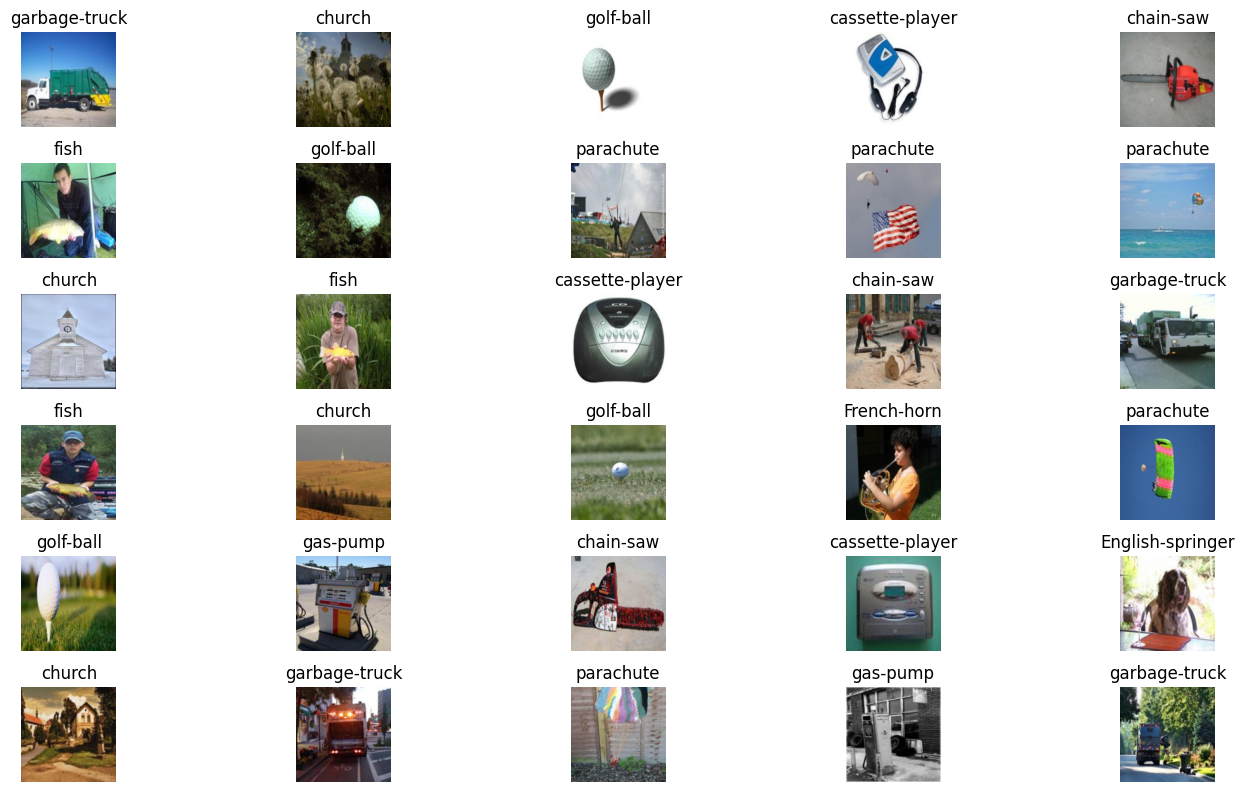

In [10]:
def visualize_data(train_dataset, num_samples):
    figure, ax = plt.subplots(nrows=num_samples//5, ncols=5, figsize=(15, 8))
    for i in range(5*(num_samples//5)):
        image, lab = train_dataset[i]
        ax.ravel()[i].imshow(np.uint8(image))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_data(train_dataset, 30 )

### Load the entire dataset.

In [11]:
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)
test_dataset = ImageDataset(test_image_paths, img_shape=img_size, is_tensor=False)

train_batch_size = train_dataset.__len__()
test_batch_size = test_dataset.__len__()

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=True
)

iterator = iter(train_loader)
for batch_train in train_loader:
    X_train, y_train = batch_train

iterator = iter(test_loader)
for batch_test in test_loader:
    X_test, y_test = batch_test

X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [12]:
# Take a smaller subset of the training set for efficient execution of kNN
# We also create a small validation set

if DEBUG:
  knn_num_train = 1900
  knn_num_val = 100
  knn_num_test =  700
else:
  knn_num_train = 9000
  knn_num_val = 538
  knn_num_test =  3856

# Create a dictionary of data for easy access when testing
knn_data_dict = {}

knn_data_dict['X_train'] = X_train[:knn_num_train].reshape(knn_num_train, -1)
knn_data_dict['y_train'] = y_train[:knn_num_train]

knn_data_dict['X_val'] = X_train[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]

knn_data_dict['X_test'] = X_test[:knn_num_test].reshape(knn_num_test, -1)
knn_data_dict['y_test'] = y_test[:knn_num_test]


print('Train data shape: ', knn_data_dict['X_train'].shape)
print('Train labels shape: ', knn_data_dict['y_train'].shape)
print('Validation data shape: ', knn_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_data_dict['y_val'].shape)
print('Test data shape: ', knn_data_dict['X_test'].shape)
print('Test labels shape: ', knn_data_dict['y_test'].shape)


Train data shape:  (9000, 3072)
Train labels shape:  (9000,)
Validation data shape:  (538, 3072)
Validation labels shape:  (538,)
Test data shape:  (3856, 3072)
Test labels shape:  (3856,)


## **Problem 3.1**

### (a) Define the KNearestNeighbor class

In [13]:
from collections import Counter
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):

        # ===== your code here! =====

        # TODO:
        # Compute the l2 distance between the ith test image and the jth
        # training image, and store the result in dists[i, j].

        # L2 distance between test point X[i] and training point self.X_train[j]
            dists[i, j] = np.sqrt(np.sum(np.square(X[i] - self.X_train[j])))
        # ==== end of code ====
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):

      # ===== your code here! =====

      # TODO:
      # Compute the l2 distance between the ith test point and all training
      # points, and store the result in dists[i, :].
      # Do not use np.linalg.norm().

      # l2 distance between each test and train using a single loop
      dists[i, :] = np.sqrt(np.sum(np.square(X[i] - self.X_train), axis=1))


      # ==== end of code ====

    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # ===== your code here! =====

    # TODO:
    # Compute the l2 distance between all test points and all training
    # points without using any explicit loops, and store the result in
    # dists.
    #
    # You should implement this function using only basic array operations;
    # in particular you should not use functions from scipy.
    #
    # HINT: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x y^T
    test_square = np.sum(np.square(X), axis=1, keepdims=True)
    train_square = np.sum(np.square(self.X_train), axis=1, keepdims=True).T
    dists = np.sqrt(test_square + train_square - 2 * np.dot(X, self.X_train.T))


    # ==== end of code ====

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    - knn_idxs: List of arrays, containing Indexes of the k nearest neighbors
      for the test data. So, for num_tests, it will be a list of length
      num_tests with each element of the list, an array of size 'k'. This will
      be used for visualization purposes later.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    knn_idxs = []
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.

      closest_y = []

      # ===== your code here! =====

      # TODO:
      # Use the distance matrix to find the k nearest neighbors of the ith
      # testing element, and use self.y_train to find the labels of these
      # neighbors. Store these labels in closest_y.
      # Also, don't forget to apprpriately store indices knn_idxs list.
      # Hint: Look up the function numpy.argsort.
      close_idxs = np.argsort(dists[i])[:k]  # collect the  indices of k smallest distances
      knn_idxs.append(close_idxs)  # indices for visualization are stored
      closest_y = self.y_train[close_idxs]  # Get corresponding labels

      # ==== end of code ====

      # Now that you have found the labels of the k nearest neighbors, the code
      # below finds the most common label in the list closest_y of labels.
      # and stores this label in y_pred[i]. We break ties by choosing the
      # smaller label.

      vote = Counter(closest_y)
      count = vote.most_common()
      y_pred[i] = count[0][0]

    return y_pred, knn_idxs

### (b) Check L2 distance implementation
Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using ***compute_distance_two_loops*** function and check the accuracies for k=1 and k=3.
Then, we will compare the ***compute_distance_one_loop*** and ***compute_distance_no_loop*** functions with it to check their consistency with the ***compute_distance_two_loops*** function.

Initialize the KNN Classifier

In [14]:
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])

Compute the distance between the training and test set.
This might take some time to run since we are running the two loops function which is not efficient.

**6 to 8 mins for full dataset | 2 to 3 mins for debug dataset**

In [15]:
dists_two = classifier.compute_distances_two_loops(knn_data_dict['X_test'])

Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using compute_distance_two_loops function and check the accuracies for k=1 and k=3.
Then, we will compare the compute_distance_one_loop and compute_distance_no_loop functions with it to check their correctness.


Predict labels and check accuracy for k = 1.
You should expect to see approximately 28% accuracy for full dataset.  
**(Accuracy below 24% on full dataset (Debug = False) will not be given full grades)**

In [16]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_two, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1123 / 3856 correct => accuracy: 0.291234


Let's predict the labels and calculate accuracy for k = 3.
You should expect to see a slightly better performance than with k=1. Around 30% accuracy (Not counted for grading)

In [17]:
y_test_pred, k_idxs = classifier.predict_labels(dists_two, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1163 / 3856 correct => accuracy: 0.301608


Now lets check the one loop implementation. This should also take some time to run.  
**4 to 6 mins for full dataset | 1 to 2 mins for debug dataset**

**Note:** This function can possibly take a little more time that two loop implementaion because of some quirks in python, numpy and cpu processing. It is fine as long as the final output shows no difference below.

In [18]:
# Implement the function compute_distances_one_loop in KNearestNeighbor class
# and run the code below:
dists_one = classifier.compute_distances_one_loop(knn_data_dict['X_test'])

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

difference = np.linalg.norm(dists_two - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Now lets check the vectorized implementation. This should take less than 30 secs to run for full dataset.

In [19]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_no = classifier.compute_distances_no_loops(knn_data_dict['X_test'])

# check that the dist ance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_two - dists_no, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Let's compare how fast the implementations are
You should see significantly faster performance with the fully vectorized implementation

In [20]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, knn_data_dict['X_test'])
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, knn_data_dict['X_test'])
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, knn_data_dict['X_test'])
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 388.446536 seconds
One loop version took 620.409581 seconds
No loop version took 4.197811 seconds


### (c) Use the validation set for tuning the value of 'K'

In [21]:
k_choices = [1, 3, 5, 6, 7, 8, 9, 10, 12, 15, 20, 50, 100]
k_accuracies = np.zeros((len(k_choices), ))
classifier = KNearestNeighbor()
max_accuracy = 0
max_k = 0

classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_data_dict['X_val'])
for ik, k in enumerate(k_choices):

  # ===== your code here! =====

  # TODO:
  # Find the accuracies for all the k values given in k_choices. You need to
  # use the validation set from the dictionary knn_data_dict already defined
  # for prediction and find its k nearest neighbors in the training set.
  # Note: Access the dataset using the knn_data_dict dictinoary defined earlier.

  # HINT: See how we had used the KNearestNeighbor() class
  # functions for k=1 and k=5 in the above cells.
  y_pred, _ = classifier.predict(knn_data_dict['X_val'], k=k)
  accuracy = np.mean(y_pred == knn_data_dict['y_val'])
  k_accuracies[ik] = accuracy

  # ==== end of code ====

  if(k_accuracies[ik] > max_accuracy):
    max_accuracy = k_accuracies[ik]
    max_k = k
  print("k = %d, accuracy = %f" %(k, k_accuracies[ik]))

print("Maximum validation accuracy obtained is: %f for k = %d" %(max_accuracy,max_k))

k = 1, accuracy = 0.260223
k = 3, accuracy = 0.258364
k = 5, accuracy = 0.286245
k = 6, accuracy = 0.284387
k = 7, accuracy = 0.291822
k = 8, accuracy = 0.308550
k = 9, accuracy = 0.310409
k = 10, accuracy = 0.297398
k = 12, accuracy = 0.310409
k = 15, accuracy = 0.317844
k = 20, accuracy = 0.304833
k = 50, accuracy = 0.315985
k = 100, accuracy = 0.308550
Maximum validation accuracy obtained is: 0.317844 for k = 15


Text(0, 0.5, 'Validation Accuracies')

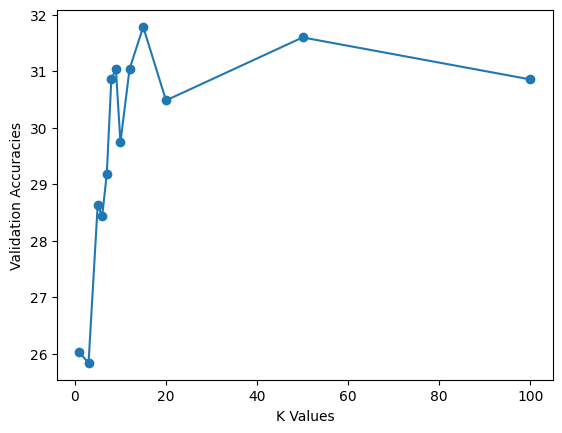

In [22]:
plt.plot(k_choices, 100*k_accuracies, 'o-')
plt.xlabel('K Values')
plt.ylabel('Validation Accuracies')

### **TODO**:
Report the best accuracy and the corresponding k value in this cell below:


Use the best k value you found from the validation set to evaluate you final accuracy on the test set

In [23]:
# Set the value of best_k to be equal to the 'k' which gave the best accuracy
# for the validation set.

best_k = max_k
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_data_dict['X_test'])
y_test_pred, k_idxs  = classifier.predict_labels(dists, k=best_k)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))


Got 1238 / 3856 correct => accuracy: 0.321058


### Visualize KNN results

Let's visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels.  

Here the leftmost column is the input image from the test set and rest of the
columns are the K nearest neighbors from the training set

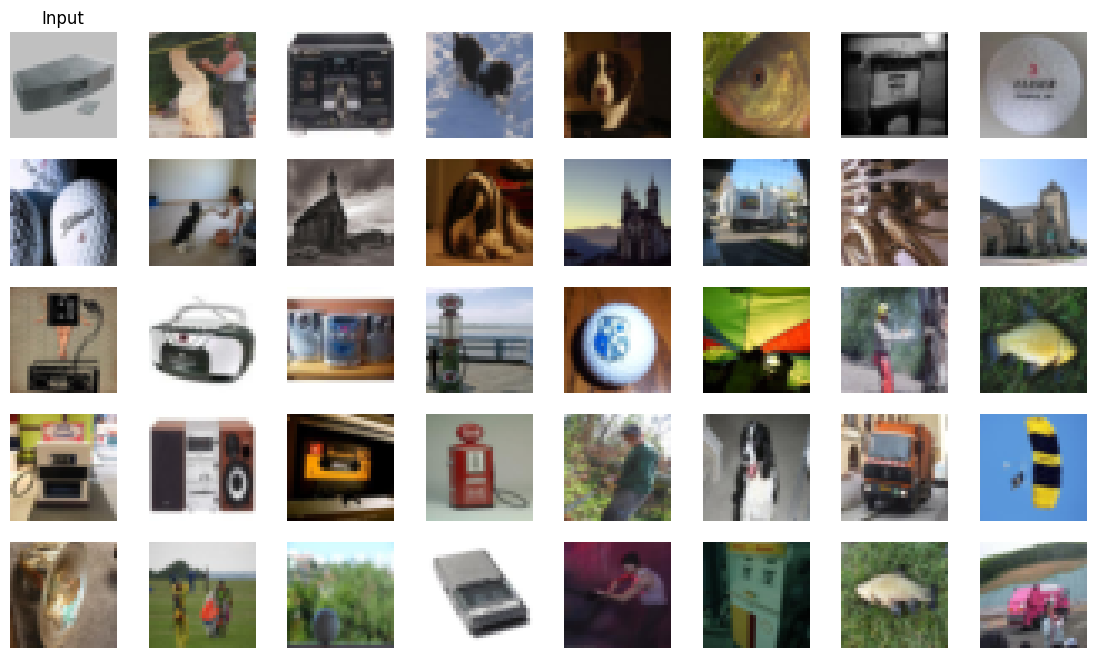

In [24]:
def visualize_knn(num_examples, K):

  idxs = np.random.choice(knn_num_test, num_examples,replace=False)
  vis_im = knn_data_dict['X_test'][idxs]
  _, k_idxs = classifier.predict_labels(dists, k=K)
  vis_labels = np.stack(k_idxs, axis=0)[idxs].astype('uint8')

  num_images = num_examples*K + num_examples

  plt.figure(figsize=(14,8))
  for i in range(num_images):
    plt.subplot(num_examples,K+1,i+1)
    if (i%(K+1) == 0):
      plt.imshow(vis_im[int(i/(K+1))].reshape(img_size,img_size,3).astype('uint8'), interpolation='nearest')
      plt.axis('off')
      if(i==0):
        plt.title('Input')
    else:
      plt.imshow(knn_data_dict['X_train'][vis_labels[int(i/(K+1)), i - (K+1)*int(i/(K+1)) - 1]].reshape(img_size,img_size,3).astype('uint8'))
      plt.axis('off')


# Here the leftmost column is the input image from the test set and rest of the
# K columns are the K nearest neighbors from the training set
num_examples = 5
K = 7
visualize_knn(num_examples, K)

### *(Optional)* Does normalizing the images give better accuracy?

We normalize each image here by subtracting the image by its mean and dividing by its standard deviation.

In [25]:
X_instance_mean = np.mean(X_train, axis = (1, 2, 3))
X_instance_std = np.std(X_train, axis = (1, 2, 3))
X_test_instance_mean = np.mean(X_test, axis = (1, 2, 3))
X_test_instance_std = np.std(X_test, axis = (1, 2, 3))
X_train_instance = (X_train - X_instance_mean[:, None, None, None])/X_instance_std[:, None, None, None]
X_test_instance = (X_test - X_test_instance_mean[:, None, None, None])/X_test_instance_std[:, None, None, None]

Store these tensors into a dictionary ``` knn_norm_data_dict ```





In [26]:
knn_norm_data_dict = {}

knn_norm_data_dict['X_train'] = X_train_instance[:knn_num_train].reshape(knn_num_train, -1)
knn_norm_data_dict['y_train'] = y_train[:knn_num_train]
knn_norm_data_dict['X_val'] = X_train_instance[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_norm_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_norm_data_dict['X_test'] = X_test_instance[:knn_num_test].reshape(knn_num_test, -1)
knn_norm_data_dict['y_test'] = y_test[:knn_num_test]

print('Train data shape: ', knn_norm_data_dict['X_train'].shape)
print('Train labels shape: ', knn_norm_data_dict['y_train'].shape)
print('Validation data shape: ', knn_norm_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_norm_data_dict['y_val'].shape)
print('Test data shape: ', knn_norm_data_dict['X_test'].shape)
print('Test labels shape: ', knn_norm_data_dict['y_test'].shape)

Train data shape:  (9000, 3072)
Train labels shape:  (9000,)
Validation data shape:  (538, 3072)
Validation labels shape:  (538,)
Test data shape:  (3856, 3072)
Test labels shape:  (3856,)


We calculate the accuracies again using k = 1 and k = 3 and see that the accuracies are much better compared to those we obtained without any preprocessing on the images!

In [27]:
classifier = KNearestNeighbor()
classifier.train(knn_norm_data_dict['X_train'], knn_norm_data_dict['y_train'])

In [28]:
dists = classifier.compute_distances_no_loops(knn_norm_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=1)

In [29]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1296 / 3856 correct => accuracy: 0.336100


In [30]:
y_test_pred, k_labels = classifier.predict_labels(dists, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1333 / 3856 correct => accuracy: 0.345695


## (d) KNN with HOG
The previous parts all directly used raw pixels from input images to compute distances with k-NN. In this part, we will first use the Histogram of Oriented Gradients (HOG) as features for each image. We will use these features with our kNN implementation to find the nearest neighbours. Please read the descriptions and fill in the functions below.

In [31]:
def compute_angles(image):
  """
    Computes the gradients in both x and y directions.
    Computes the magnitudes of the gradients.
    Computes the angles from the gradients and map to range [0, 180 deg].
    Inputs:
    - image: A numpy array of shape (32, 32) containing one grayscaled image.
    Returns:
    - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
      is the magnitude of the gradient at the (i, j) pixel in the input image.
    - angles: A numpy array of shape (32, 32) where angles[i, j]
      is the angle of the gradient at the (i, j) pixel in the input image.
    """

  # ===== your code here! =====

  # TODO:
  # Compute the gradients along the rows and columns as two arrays.
  # Compute the magnitude as the square root of the sum of the squares of both gradients
  # Compute the angles as the inverse tangent of the gradients along the rows and
  # the gradients along the columns, and map them to the range [0, 180 deg]
  grad_x = np.gradient(image, axis=1)
  grad_y = np.gradient(image, axis=0)
  magnitudes = np.sqrt(grad_x**2 + grad_y**2)
  angles = np.arctan2(grad_y, grad_x)
  angles = np.degrees(angles)
  angles = (angles + 180) % 180

  # ==== end of code ====
  return magnitudes, angles

In [32]:
def compute_hog(angles, magnitudes, num_bins, pixels_per_cell, cells_per_block):
  """
  Creates a Histogram of Oriented Gradients (HOG) weighted by gradient
  magnitudes from the orientations and magnitudes of an image
  Inputs:
  - angles: A numpy array of shape (32, 32) where angles[i, j]
      is the angle of the gradient at the (i, j) pixel in the input image.
  - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
      is the magnitude of the gradient at the (i, j) pixel in the input image.
  - num_bins: An int of the number of different bins in the histogram
    representing intervals of different orientations
  - pixels_per_cell: An int representing the number of rows/columns of pixels
    present in each cell
  - cells_per_block: An int representing the number of rows/columns of cells
    present in each block
  """

  num_cell_rows = angles.shape[0] // pixels_per_cell
  histogram = np.zeros((num_cell_rows, num_cell_rows, num_bins));
  step_size = 180 // num_bins

  # ===== your code here! =====

  # TODO:
  # Iterate through each pixel in every cell
  # Find the index to the bin in histogram for that pixel's orientation
  # Add the weighted magnitude to the corresponding bins in the histogram

  num_cell_cols = angles.shape[1]

  for i in range(num_cell_rows):
      for j in range(num_cell_cols):
          cell_angles = angles[i * pixels_per_cell:(i + 1) * pixels_per_cell,j * pixels_per_cell:(j + 1) * pixels_per_cell] # Extract the pixel angles and magnitudes for the current cell
          cell_magnitudes = magnitudes[i * pixels_per_cell:(i + 1) * pixels_per_cell,j * pixels_per_cell:(j + 1) * pixels_per_cell]

          for pixel_angle, pixel_magnitude in zip(cell_angles.ravel(), cell_magnitudes.ravel()): # histogram for the cell
              bin_idx = int(pixel_angle // step_size) % num_bins # Compute the bin index for this angle
              histogram[i, j, bin_idx] += pixel_magnitude # Add the magnitude into resp bin
  # ==== end of code ====

  normalize_histogram(histogram, num_cell_rows, cells_per_block, epsilon=1e-5)
  return histogram.flatten()

**NOTE :** Once we create a histogram based on the gradient of the image we need to normalize it. Gradients of an image are sensitive to overall lighting. If you make the image darker by dividing all pixel values by 2, the gradient magnitude will change by half, and therefore the histogram values will change by half.

Ideally, we want our image features to be independent of lighting variations. In other words, we would like to “normalize” the histogram so they are not affected by lighting variations.

We have provided the normalization code below.

In [33]:
def normalize_histogram(histogram, num_cell_rows, cells_per_block, epsilon=1e-5):
  """
  Normalizes the histogram in blocks of size cells_per_block.
  Inputs:
  - histogram: A numpy array of shape (num_cell_rows, num_cell_rows, num_bins)
    representing the histogram of oriented gradients of the input image.
    It can be modified in place.
  - num_cell_rows: An int representing the number of rows/columns of cells
    in the input image.
  - cells_per_block: An int representing the number of rows/coluns of cells that
    should together be normalized in the same block.
  - epsilon: A float indicating the small amount added to the denominator when
    normalizing to avoid dividing by zero.
  """

  num_block_rows = num_cell_rows // cells_per_block
  # Block normalization
  for r in range(num_block_rows):
    for c in range(num_block_rows):
      histogram[r : r + cells_per_block, c : c + cells_per_block, :] /= np.sqrt(np.sum(np.square(histogram[r : r + cells_per_block, c : c + cells_per_block, :])) + epsilon ** 2)

After implementing your HOG functions, please run the cells below to test the results. You should expect to get an accuracy slightly higher than that with unnormalized raw pixels.

In [34]:
def generate_histogram(image):
  """
  Builds a Histogram of Oriented Gradients (HOG) weighted by gradient magnitudes
  from an input image
  Inputs:
  - image: A numpy array of shape (32, 32) containing one grayscaled image.
  Outputs:
  - histogram: A 1D numpy array of shape
    (num_cell_rows * num_cell_rows * num_bins, ) that shows a HOG of an image.
  """
  # Read and reshape input image
  input_image = image.reshape((img_size, img_size, 3)).astype('uint8')
  grayscaled = rgb2gray(input_image)
  magnitudes, angles = compute_angles(grayscaled)

  # 9 bin, histogram with 64 4x4 pixel cells, normalize 4 cells per block
  # Get histogram of 4 quadrants with 9 bins concatenated into a 8x8x9-dimensional vector

  histogram = compute_hog(angles=angles, magnitudes=magnitudes, num_bins=9, pixels_per_cell=4, cells_per_block=4)

  return histogram

This part will take some time to run for the full dataset. Approx 1 to 2mins.

In [35]:
X_train_hog = []
for image_index in range(X_train.shape[0]):
  histogram = generate_histogram(X_train[image_index])
  X_train_hog.append(histogram)

X_test_hog = []
for image_index in range(X_test.shape[0]):
  histogram = generate_histogram(X_test[image_index])
  X_test_hog.append(histogram)

Store these tensors into a dictionary ``` knn_hog_data_dict ```





In [36]:
knn_hog_data_dict = {}

knn_hog_data_dict['X_train'] = np.array(X_train_hog[:knn_num_train]).reshape(knn_num_train, -1)
knn_hog_data_dict['y_train'] = y_train[:knn_num_train]
knn_hog_data_dict['X_val'] = np.array(X_train_hog[knn_num_train:knn_num_train+knn_num_val]).reshape(knn_num_val, -1)
knn_hog_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_hog_data_dict['X_test'] = np.array(X_test_hog[:knn_num_test]).reshape(knn_num_test, -1)
knn_hog_data_dict['y_test'] = y_test[:knn_num_test]

print('Train data shape: ', knn_hog_data_dict['X_train'].shape)
print('Train labels shape: ', knn_hog_data_dict['y_train'].shape)
print('Validation data shape: ', knn_hog_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_hog_data_dict['y_val'].shape)
print('Test data shape: ', knn_hog_data_dict['X_test'].shape)
print('Test labels shape: ', knn_hog_data_dict['y_test'].shape)

Train data shape:  (9000, 576)
Train labels shape:  (9000,)
Validation data shape:  (538, 576)
Validation labels shape:  (538,)
Test data shape:  (3856, 576)
Test labels shape:  (3856,)


In [37]:
classifier = KNearestNeighbor()
classifier.train(knn_hog_data_dict['X_train'], knn_hog_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_hog_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)

In [38]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_hog_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1100 / 3856 correct => accuracy: 0.285270


You can also visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels trained with HOG descriptors.

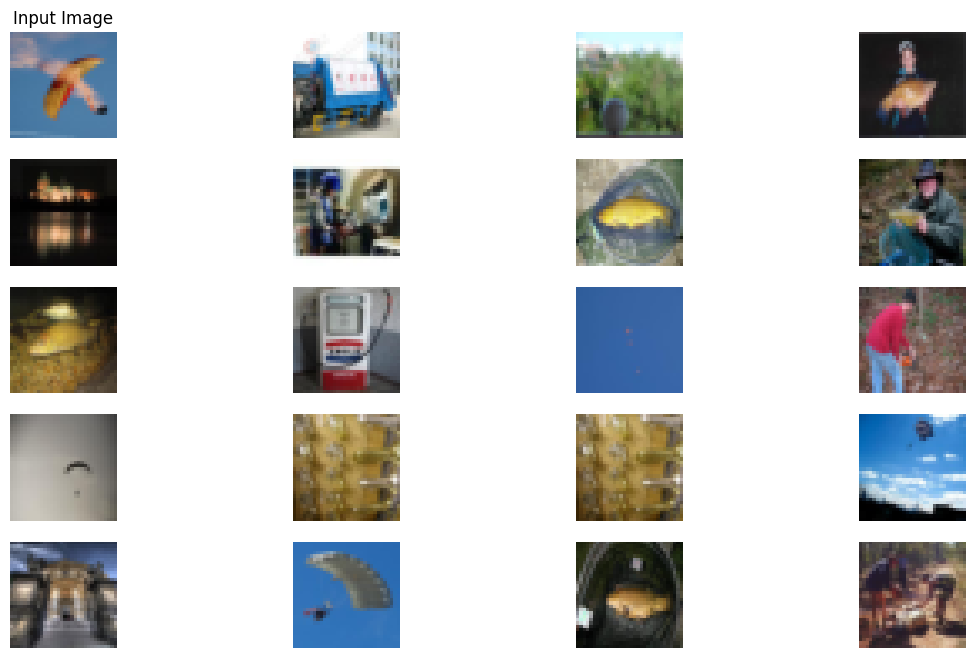

In [39]:
def visualize_knn_sift(num_examples, K):
  idxs = np.random.choice(knn_num_test, num_examples,replace=False)
  vis_im = knn_data_dict['X_test'][idxs]
  vis_labels = np.stack(k_labels, axis=0)[idxs].astype('uint8')

  num_images = num_examples*K + num_examples
  plt.figure(figsize=(14,8))
  for i in range(num_images):
    plt.subplot(num_examples,K+1,i+1)
    if (i%(K+1) == 0):
      plt.imshow(vis_im[int(i/(K+1))].reshape(img_size,img_size,3).astype('uint8'), interpolation='nearest')
      plt.axis('off')
      if(i==0):
        plt.title('Input Image')
    else:
      plt.imshow(knn_data_dict['X_train'][vis_labels[int(i/(K+1)), i - (K+1)*int(i/(K+1)) - 1]].reshape(img_size,img_size,3).astype('uint8'))
      plt.axis('off')



# Here the leftmost column is the input image from the test set and rest of the
# K columns are the K nearest neighbors from the training set
num_examples = 5
K = 3
visualize_knn_sift(num_examples, K)

### (e) (EXTRA) scikit-image’s HOG implementation
We have provided the Skimage implementation that computes full HOG features. These features should obtain significantly higher accuracy. You can read about it further [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

In [40]:
X_train_skimage_hog = []
for image_index in range(X_train.shape[0]):
  histogram = hog(X_train[image_index], pixels_per_cell=(4, 4), cells_per_block=(4, 4), channel_axis=-1)
  X_train_skimage_hog.append(histogram)

X_test_skimage_hog = []
for image_index in range(X_test.shape[0]):
  histogram = hog(X_test[image_index], pixels_per_cell=(4, 4), cells_per_block=(4, 4), channel_axis=-1)
  X_test_skimage_hog.append(histogram)

knn_skimage_hog_data_dict = {}

knn_skimage_hog_data_dict['X_train'] = np.array(X_train_skimage_hog[:knn_num_train]).reshape(knn_num_train, -1)
knn_skimage_hog_data_dict['y_train'] = y_train[:knn_num_train]
knn_skimage_hog_data_dict['X_val'] = np.array(X_train_skimage_hog[knn_num_train:knn_num_train+knn_num_val]).reshape(knn_num_val, -1)
knn_skimage_hog_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_skimage_hog_data_dict['X_test'] = np.array(X_test_skimage_hog[:knn_num_test]).reshape(knn_num_test, -1)
knn_skimage_hog_data_dict['y_test'] = y_test[:knn_num_test]

In [41]:
classifier = KNearestNeighbor()
classifier.train(knn_skimage_hog_data_dict['X_train'], knn_skimage_hog_data_dict['y_train'])

dists = classifier.compute_distances_no_loops(knn_skimage_hog_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)

In [42]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_skimage_hog_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 1604 / 3856 correct => accuracy: 0.415975


## **Problem 3.2**
Linear classifier with Softmax Loss

### Preprocess images

We need 1-D vectors to use  with Linear classifer. Hence in this function below we flatten the ``` [N, 32, 32, 3] ``` images into one dimesional arrays of shape ``` [N, 3072] ``` and we append a row of ones for each image, to accomodate for the bias when using the bias trick. This makes the shape of the input images ``` [N, 3073] ```. We also normalize the data by subtracting the mean image from the train and test data.   

In [43]:
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)
test_dataset = ImageDataset(test_image_paths, img_shape=img_size, is_tensor=False)

train_batch_size = train_dataset.__len__()
test_batch_size = test_dataset.__len__()

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=True
)

iterator = iter(train_loader)
# X_train, y_train = iter(train_loader).next()
for batch_train in train_loader:
    X_train, y_train = batch_train

iterator = iter(test_loader)
# X_test, y_test = iter(test_loader).next()
for batch_test in test_loader:
    X_test, y_test = batch_test

X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9538, 32, 32, 3)
(9538,)
(3856, 32, 32, 3)
(3856,)


In [45]:
if DEBUG:
  num_training=1900
  num_validation=100
  num_test=3925
else:
  num_training=9000
  num_validation=538
  num_test=3856

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data: subtract the mean image from train and test data
mean_image = np.mean(X_train, axis=0, keepdims=True)
X_train -= mean_image
X_test -= mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
ones_train = np.ones((X_train.shape[0],1))
X_train = np.concatenate((X_train, ones_train), axis=1)
ones_test = np.ones((X_test.shape[0],1))
X_test = np.concatenate((X_test, ones_test), axis=1)

# Store them in a dictionary.
data_dict={}
data_dict['X_train'] = X_train[0:num_training]
data_dict['y_train'] = y_train[0:num_training]
data_dict['X_val'] = X_train[num_training:num_training+num_validation]
data_dict['y_val'] = y_train[num_training:num_training+num_validation]
data_dict['X_test'] = X_test[0:num_test]
data_dict['y_test'] = y_test[0:num_test]

print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

Train data shape:  (9000, 3073)
Train labels shape:  (9000,)
Validation data shape:  (538, 3073)
Validation labels shape:  (538,)
Test data shape:  (3856, 3073)
Test labels shape:  (3856,)


### (a) Softmax_loss_naive function

In [46]:
def softmax_loss_naive(W, X, y):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  Returns a tuple of:
  - loss: loss as single float
  - dW: gradient with respect to weights W averaged across the whole batch;
     an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  num_classes = W.shape[1]
  num_train = X.shape[0]

  # ===== your code here! =====

  # TODO:
  # Loop over each example in the batch
  # Calculate the scores
  # Compute the softmax loss
  # Compute gradient dW using explicit loop
  # Average loss and gradient across the whole batch
  # Note: When calculating dW, subtract the maximum score from each scores to
  # avoid infinity (See note in the PSet).
  for i in range(num_train):
      scores = X[i].dot(W)  # shape (C,)
      max_score = np.max(scores)
      scores -= max_score
      # softmax probabilities
      exp_scores = np.exp(scores)
      probs = exp_scores / np.sum(exp_scores)
      # loss for the correct class (cross-entropy)
      correct_class = y[i]
      loss += -np.log(probs[correct_class])
      # gradient (dW)
      for j in range(num_classes):
          if j == correct_class:
              dW[:, j] += (probs[j] - 1) * X[i]
          else:
              dW[:, j] += probs[j] * X[i]

  # Average of the loss and the gradient
  loss /= num_train
  dW /= num_train

  # ==== end of code ====

  return loss, dW

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. **If your implementation is correct you should see loss near  -ln(1/10) = 2.3**








In [47]:
# Generate a random weight matrix of small numbers and use it to compute the loss
random.seed(0)
np.random.seed(0)
W = np.random.randn((img_size*img_size*3)+1, 10) * 0.00001

# For debugging purpose we can calculate the loss with very low W and no regularization
# The result should be near log(10) (log(#number_class))

loss, grad = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
print('loss: %f' % (loss))
print('sanity check: %f' % (np.log(10.0)))

loss: 2.305376
sanity check: 2.302585


To check that you have implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you    

 **(The relative errors should be less than 1e-6)**.


In [48]:
# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.

f = lambda w: softmax_loss_naive(w, data_dict['X_val'], data_dict['y_val'])[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.791810 analytic: 0.791810, relative error: 6.704432e-08
numerical: -1.794543 analytic: -1.794543, relative error: 2.180849e-08
numerical: -0.088214 analytic: -0.088214, relative error: 5.427018e-07
numerical: 0.873959 analytic: 0.873959, relative error: 1.052096e-07
numerical: 0.415231 analytic: 0.415231, relative error: 2.152956e-07
numerical: -4.075170 analytic: -4.075170, relative error: 1.006134e-08
numerical: 0.730062 analytic: 0.730062, relative error: 1.661319e-08
numerical: -2.608664 analytic: -2.608664, relative error: 3.673365e-08
numerical: -0.259465 analytic: -0.259466, relative error: 1.673975e-07
numerical: -0.230834 analytic: -0.230834, relative error: 1.151291e-07


Next, we implement a vecotrized version of the softmax loss for you, for faster execution, as we quantify the speedup in the below cells. If you want to get a flavor of writing optimized (vectorized) code in the future for Deep Learning systems as well as future homeworks, it might be helpful to go through this function **AFTER** finishing the required parts of the Problem Set

In [49]:
def softmax_loss_vectorized(W, X, y):
  """
  Softmax loss function, vectorized version.
  Inputs and outputs are the same as softmax_loss_naive.
  """

  dW = np.zeros(W.shape) # initialize the gradient as zero
  loss = 0.0             # initialize the loss as zero

  num_train = X.shape[0]
  scores = X.dot(W)
  scores -= np.max(scores, axis =1, keepdims = True)
  exp_scores = np.exp(scores)
  scores_exp_sum = np.sum(exp_scores, axis=1, keepdims=True)
  norm_scores = exp_scores/(scores_exp_sum + 1e-12)
  loss = np.sum(-np.log(norm_scores[range(num_train),y]))

  norm_scores[np.arange(num_train),y] -= 1
  dW = np.matmul(X.T, norm_scores)

  loss/=num_train
  dW/=num_train

  return loss,dW

In [50]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# we have provided a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vectorized, ms_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Speedup: %f' %(ms_naive/ms_vec))

naive loss: 2.305376e+00 computed in 88.310719s
vectorized loss: 2.305376e+00 computed in 8.924723s
Loss difference: 0.000000
Gradient difference: 0.000000
Speedup: 9.895066


### (b) Define Linear Classifier class

In [51]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y,  X_val, y_val, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
    """

    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.000001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # ==== your code here ! ====

      # TODO:
      # Sample batch_size elements from the training data and their
      # corresponding labels to use them as arguments for the loss
      # function. Store the data in X_batch and their corresponding labels
      # in y_batch.

      # Hint: Use np.random.choice to generate indices. Sampling with
      # replacement is faster than sampling without replacement.
      batch_indices = np.random.choice(num_train, batch_size, replace=True)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      # ===== end of code =====

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch)
      loss_history.append(loss)

      # perform parameter update

      # ==== your code here ! ====

      # TODO:
      # Update the weights using the gradient and the learning rate.
      self.W -= learning_rate * grad

      # ===== end of code =====

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      y_val_pred = self.predict(X_val)
      val_accuracy = np.mean(y_val == y_val_pred)

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    # ==== your code here ! ====
    # TODO:
    # Calculate the scores and store the predicted labels in y_pred.
    scores = X.dot(self.W)
    y_pred = np.argmax(scores, axis=1)
    # ===== end of code =====
    return y_pred

  def loss(self, X_batch, y_batch):
    """
    Compute the loss function and its derivative.
    Subclasses will override this.
    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.
    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass

class LinearSoftmax(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch):
    return softmax_loss_vectorized(self.W, X_batch, y_batch)

### (d) Train and test the classifier
Run the linear classifier and observe the train, validation and test accuracies and see the visualization of the weights. The loss should start around 2.300 and reduce over iterations to final value between 1.800 and 1.600.

In [52]:
softmax = LinearSoftmax()
tic = time.time()
loss_hist = softmax.train(data_dict['X_train'], data_dict['y_train'], learning_rate=1e-7,
                      num_iters=1500, verbose=True, X_val=data_dict['X_val'], y_val=data_dict['y_val'])
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.302269
iteration 100 / 1500: loss 1.978269
iteration 200 / 1500: loss 2.014157
iteration 300 / 1500: loss 1.951176
iteration 400 / 1500: loss 1.762976
iteration 500 / 1500: loss 1.878730
iteration 600 / 1500: loss 2.028747
iteration 700 / 1500: loss 1.785027
iteration 800 / 1500: loss 1.740741
iteration 900 / 1500: loss 1.832307
iteration 1000 / 1500: loss 1.749243
iteration 1100 / 1500: loss 1.764263
iteration 1200 / 1500: loss 1.703262
iteration 1300 / 1500: loss 1.822851
iteration 1400 / 1500: loss 1.742806
That took 9.656153s


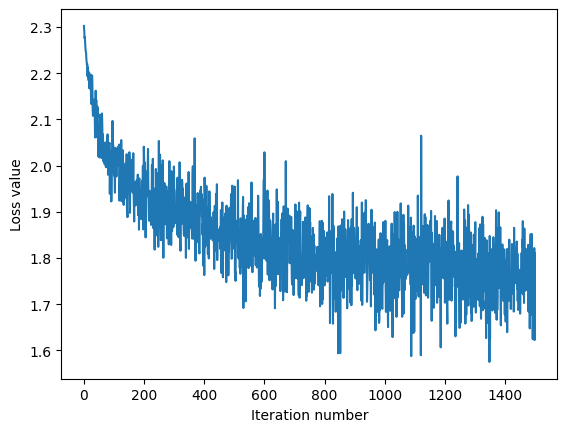

In [53]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [54]:
# Write the LinearSoftmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(data_dict['X_train'])
print('training accuracy: %f' % (np.mean(data_dict['y_train'] == y_train_pred), ))
y_val_pred = softmax.predict(data_dict['X_val'])
print('validation accuracy: %f' % (np.mean(data_dict['y_val'] == y_val_pred), ))

training accuracy: 0.417000
validation accuracy: 0.379182


In [55]:
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(data_dict['X_test'])
test_accuracy = np.mean(data_dict['y_test'] == y_test_pred)
print('Linear Softmax on raw pixels final test set accuracy: %f' % test_accuracy)

Linear Softmax on raw pixels final test set accuracy: 0.389782


 Visualize the learned weights for each class. You might be able to spot a few defining features of each class in these weights.

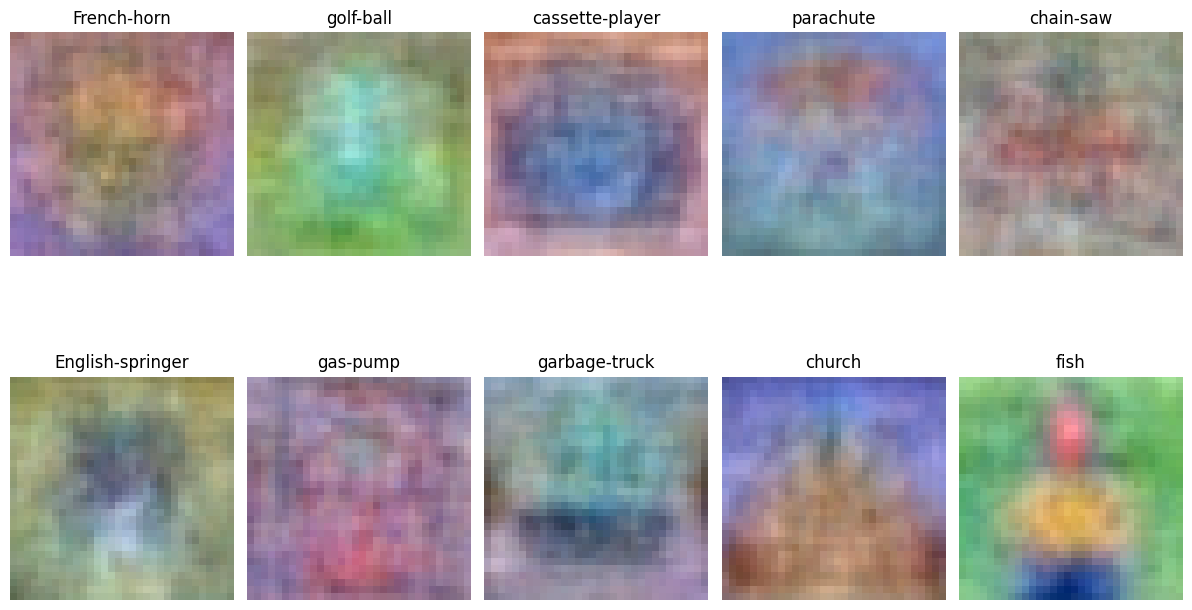

In [56]:
w = softmax.W[:-1,:] # strip out the bias
w = w.reshape(img_size, img_size, 3, 10)
w_min, w_max = np.min(w), np.max(w)

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
for i in range(10):
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    ax.ravel()[i].imshow(wimg.astype('uint8'))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[i])
plt.tight_layout(pad=1)
plt.show()

## Visualize the mean image for each class

Here we visualize an average image for each class by adding a few images and avergaing the pixel values.

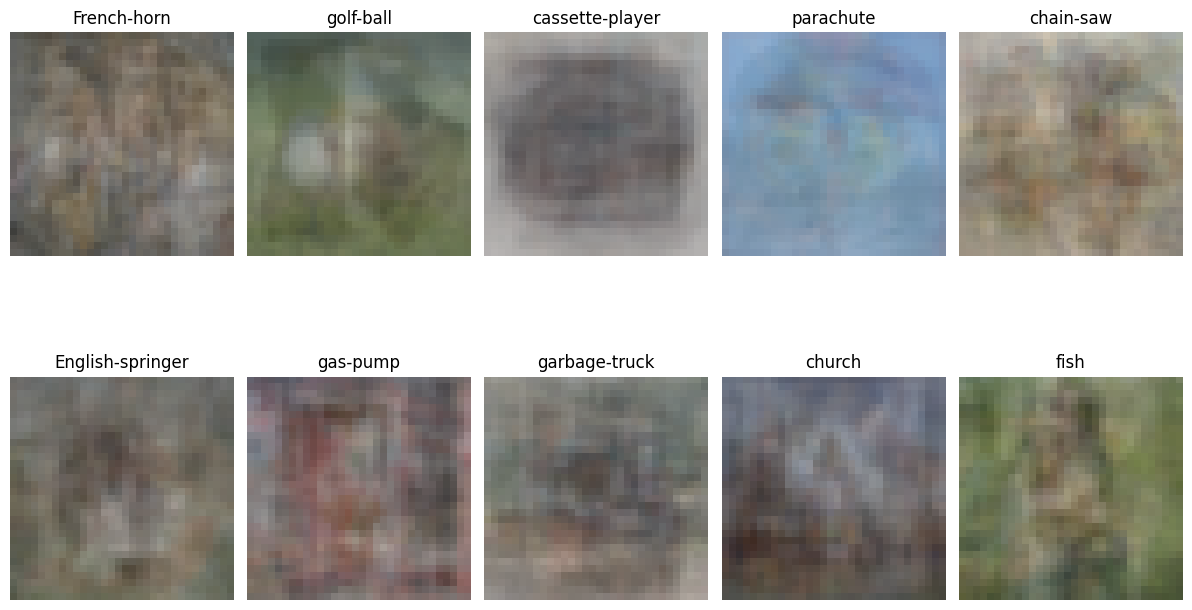

In [57]:
samples_per_class = 20
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)

train_loader = DataLoader(
    train_dataset, batch_size=samples_per_class*10, shuffle=True
)

iterator = iter(train_loader)
# X_train, y_train = iter(train_loader).next()
for batch_train in train_loader:
    X_train, y_train = batch_train


X_train = X_train.numpy()
y_train = y_train.numpy()

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
for i in range(10):
    idxs = np.flatnonzero(y_train == i)
    mean_img = np.mean(X_train[idxs], axis = 0)
    ax.ravel()[i].imshow(mean_img.reshape(img_size,img_size,3).astype('uint8'))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[i])
plt.tight_layout(pad=1)
plt.show()


# Convert Notebook to PDF

In [58]:
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '/content/drive/My Drive/Colab Notebooks/maithgan_22638966_ps3.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,113 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,348 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,317 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>